<a href="https://colab.research.google.com/github/abhy-kumar/NLPulse/blob/main/NLPulse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install feedparser TextBlob
!pip install nltk transformers torch

In [9]:
import nltk
import torch
import requests
import feedparser
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from plotly.subplots import make_subplots
from datetime import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from scipy import stats
from wordcloud import WordCloud
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline
)

# Constants
DATABASE_NAME = 'news_sentiment.db'
NEWS_FEED_URL = "https://timesofindia.indiatimes.com/rssfeedstopstories.cms"
DATE_FORMAT = "%Y-%m-%d"
DATETIME_FORMAT = "%a, %d %b %Y %H:%M:%S %z"

class SentimentAnalyzer:
    def __init__(self):
        # Initialize NLTK
        nltk.download('vader_lexicon', quiet=True)
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)

        # Initialize models
        self.sia = SentimentIntensityAnalyzer()
        self.finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
        self.finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
        self.roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        self.roberta_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    def generate_summary(self, text: str, max_length: int = 100, min_length: int = 30) -> str:
        """Generate a summary for long texts."""
        if len(text) > 1000:
            summary = self.summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
            return summary[0]['summary_text']
        return text

    def roberta_sentiment_analysis(self, text: str) -> tuple:
        """Perform sentiment analysis using RoBERTa model."""
        inputs = self.roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        outputs = self.roberta_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        sentiment = torch.argmax(probs).item()
        return sentiment * 5, torch.max(probs).item()

    def finbert_sentiment_analysis(self, text: str) -> tuple:
        """Perform sentiment analysis using FinBERT model."""
        inputs = self.finbert_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        outputs = self.finbert_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        sentiment = torch.argmax(probs).item()
        return sentiment * 5, torch.max(probs).item()

    def post_process_sentiment_score(self, text: str, score: float) -> float:
        """Post-process sentiment scores based on keyword presence."""
        negative_keywords = {'hospital', 'intensive care', 'critical', 'death', 'emergency'}
        positive_keywords = {'good spirits', 'recovery', 'improving', 'healthy'}

        text_lower = text.lower()
        if any(keyword in text_lower for keyword in negative_keywords):
            score = min(score, 4.0)

        if any(keyword in text_lower for keyword in positive_keywords) and score < 5:
            score = max(score, 6.0)

        return score

    def analyze_sentiment(self, text: str) -> float:
        """Perform comprehensive sentiment analysis using multiple models."""
        if not text or len(text.strip()) < 10:
            return 5.0

        summarized_text = self.generate_summary(text)

        # VADER analysis
        vader_scores = self.sia.polarity_scores(summarized_text)
        vader_score = (vader_scores['compound'] + 1) * 5
        vader_confidence = abs(vader_scores['compound'])

        # FinBERT analysis
        finbert_score, finbert_confidence = self.finbert_sentiment_analysis(summarized_text)

        # RoBERTa analysis
        roberta_score, roberta_confidence = self.roberta_sentiment_analysis(summarized_text)

        # Calculate weighted average
        total_confidence = finbert_confidence + vader_confidence + roberta_confidence
        weights = [
            vader_confidence / total_confidence,
            finbert_confidence / total_confidence,
            roberta_confidence / total_confidence
        ]

        scores = [vader_score, finbert_score, roberta_score]
        combined_score = sum(w * s for w, s in zip(weights, scores))

        # Ensure score is between 0 and 10
        combined_score = max(0, min(combined_score, 10))

        return self.post_process_sentiment_score(summarized_text, combined_score)



In [10]:
class DatabaseManager:
    def __init__(self, db_name: str):
        self.db_name = db_name
        self.setup_database()

    def setup_database(self):
        """Initialize the database with required tables."""
        with sqlite3.connect(self.db_name) as conn:
            conn.execute('''
                CREATE TABLE IF NOT EXISTS sentiment_scores (
                    date TEXT,
                    time TEXT,
                    title TEXT,
                    summary TEXT,
                    score REAL
                )
            ''')

    def store_score(self, date: str, time: str, title: str, summary: str, score: float):
        """Store sentiment analysis results in the database."""
        with sqlite3.connect(self.db_name) as conn:
            conn.execute(
                "INSERT INTO sentiment_scores VALUES (?, ?, ?, ?, ?)",
                (date, time, title, summary, score)
            )

    def get_daily_average(self, date: str) -> float:
        """Calculate the average sentiment score for a given date."""
        with sqlite3.connect(self.db_name) as conn:
            result = conn.execute(
                "SELECT AVG(score) FROM sentiment_scores WHERE date = ?",
                (date,)
            ).fetchone()
            return result[0] if result[0] is not None else 0.0

    def clean_database(self):
        """Remove invalid entries from the database."""
        with sqlite3.connect(self.db_name) as conn:
            conn.execute("DELETE FROM sentiment_scores WHERE LENGTH(summary) <= 2")

class NewsAnalyzer:
    def __init__(self, sentiment_analyzer: SentimentAnalyzer, db_manager: DatabaseManager):
        self.sentiment_analyzer = sentiment_analyzer
        self.db_manager = db_manager

    def fetch_and_analyze_news(self, url: str):
        """Fetch news from RSS feed and perform sentiment analysis."""
        try:
            response = requests.get(url)
            feed = feedparser.parse(response.content)

            for entry in feed.entries:
                dt = datetime.strptime(entry.published, DATETIME_FORMAT)
                date = dt.strftime(DATE_FORMAT)
                time = dt.strftime("%H:%M:%S")

                score = self.sentiment_analyzer.analyze_sentiment(entry.summary)

                self.db_manager.store_score(
                    date=date,
                    time=time,
                    title=entry.title,
                    summary=entry.summary,
                    score=score
                )

                print(f"Analyzed: {entry.title} (Score: {score:.2f})")

        except Exception as e:
            print(f"Error processing news feed: {str(e)}")



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Fetching and analyzing news...
Analyzed: Gujarat lawyer stretches long arm of law, sets up own ‘court’; arrested (Score: 2.00)
Analyzed: 'States have regulatory power over industrial alcohol': SC in 8:1 majority verdict (Score: 5.22)
Analyzed: 'Social media doesn't decide...': Gautam Gambhir on KL Rahul criticism (Score: 2.26)
Analyzed: In tiff with in-laws, UP man cooks up ‘Lawrence Bishnoi’ threat (Score: 2.15)
Analyzed: Zomato increases platform fee by over 60%, read message to customers (Score: 3.43)
Analyzed: Bombay HC grants bail to gangster Chhota Rajan in Jaya Shetty murder case (Score: 3.40)
Analyzed: Ivanka takes daughter to Taylor Swift concert despite Trump's 'hate' for singer (Score: 8.31)
Analyzed: Bill Gates concerned with Trump’s presidency says 'this election is different' (Score: 7.72)
Analyzed: Salman Khan, blackbuck and Bishnoi case: What Mika & other artist suggest (Score: 2.82)
Analyzed: Gambhir drops hint on Gill’s availability for IND vs NZ 2nd Test (Score: 6.00

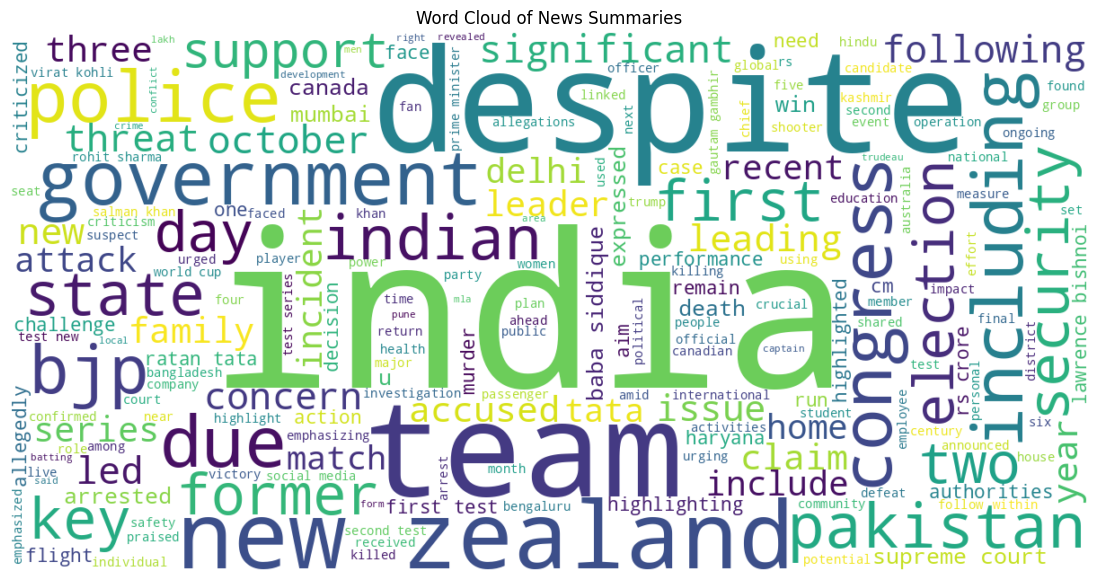

Analysis complete!


In [11]:
class DataVisualizer:
    @staticmethod
    def load_data(db_name: str) -> pd.DataFrame:
        """Load data from database into a pandas DataFrame."""
        with sqlite3.connect(db_name) as conn:
            df = pd.read_sql_query("SELECT * FROM sentiment_scores", conn)
            df['date'] = pd.to_datetime(df['date'])
            return df

    @staticmethod
    def create_word_cloud(df: pd.DataFrame):
        """Generate and display a word cloud from news summaries."""
        text = ' '.join(df['summary'])
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text.lower())
        filtered_text = [word for word in word_tokens if word.isalnum() and word not in stop_words]

        wordcloud = WordCloud(
            width=1200,
            height=600,
            background_color='white',
            max_words=200
        ).generate(' '.join(filtered_text))

        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of News Summaries')
        plt.show()

    @staticmethod
    def plot_sentiment_trends(df: pd.DataFrame):
        """Create an interactive plot showing sentiment trends over time."""
        daily_avg = df.groupby('date')['score'].agg(['mean', 'std']).reset_index()

        # Calculate rolling statistics (7-day window)
        rolling_stats = df.set_index('date').resample('D')['score'].agg(['mean', 'std']).rolling(window=7)
        rolling_mean = rolling_stats['mean'].mean()
        rolling_std = rolling_stats['std'].mean()

        fig = make_subplots(
            rows=2,
            cols=1,
            shared_xaxes=True,
            vertical_spacing=0.1,
            subplot_titles=('Daily Sentiment Trends', 'Volatility Analysis')
        )

        # Daily sentiment plot
        fig.add_trace(
            go.Scatter(
                x=daily_avg['date'],
                y=daily_avg['mean'],
                mode='lines+markers',
                name='Daily Average',
                line=dict(color='blue')
            ),
            row=1, col=1
        )

        # Add rolling mean
        fig.add_trace(
            go.Scatter(
                x=rolling_mean.index,
                y=rolling_mean,
                mode='lines',
                name='7-day Rolling Average',
                line=dict(color='red')
            ),
            row=1, col=1
        )

        # Volatility plot (standard deviation)
        fig.add_trace(
            go.Scatter(
                x=daily_avg['date'],
                y=daily_avg['std'],
                mode='lines',
                name='Daily Volatility',
                line=dict(color='orange')
            ),
            row=2, col=1
        )

        fig.update_layout(
            height=800,
            title_text="Sentiment Analysis Dashboard",
            showlegend=True
        )

        fig.show()

    @staticmethod
    def plot_sentiment_distribution(df: pd.DataFrame):
        """Create an interactive histogram of sentiment scores."""
        fig = go.Figure()

        fig.add_trace(go.Histogram(
            x=df['score'],
            nbinsx=30,
            name='Sentiment Distribution',
            showlegend=True,
            histnorm='probability density'
        ))

        # Add kernel density estimate
        kde_x = np.linspace(df['score'].min(), df['score'].max(), 100)
        kde = stats.gaussian_kde(df['score'])

        fig.add_trace(go.Scatter(
            x=kde_x,
            y=kde(kde_x),
            mode='lines',
            name='KDE',
            line=dict(color='red')
        ))

        fig.update_layout(
            title='Distribution of Sentiment Scores',
            xaxis_title='Sentiment Score',
            yaxis_title='Density',
            bargap=0.1
        )

        fig.show()

def main():
    # Initialize components
    sentiment_analyzer = SentimentAnalyzer()
    db_manager = DatabaseManager(DATABASE_NAME)
    news_analyzer = NewsAnalyzer(sentiment_analyzer, db_manager)

    # Fetch and analyze news
    print("Fetching and analyzing news...")
    news_analyzer.fetch_and_analyze_news(NEWS_FEED_URL)

    # Clean database
    db_manager.clean_database()

    # Create visualizations
    print("\nGenerating visualizations...")
    df = DataVisualizer.load_data(DATABASE_NAME)

    DataVisualizer.create_word_cloud(df)
    DataVisualizer.plot_sentiment_trends(df)
    DataVisualizer.plot_sentiment_distribution(df)

    print("Analysis complete!")

if __name__ == "__main__":
    main()

In [13]:
import sqlite3
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime

class DatabaseInspector:
    def __init__(self, db_name: str):
        self.db_name = db_name

    def get_database_stats(self) -> dict:
        """Get comprehensive statistics about the database contents."""
        with sqlite3.connect(self.db_name) as conn:
            df = pd.read_sql_query("SELECT * FROM sentiment_scores", conn)

            if df.empty:
                return {"error": "Database is empty"}

            # Basic statistics
            stats = {
                "total_entries": len(df),
                "first_entry_date": df['date'].min(),
                "last_entry_date": df['date'].max(),
                "unique_dates": df['date'].nunique(),
                "average_entries_per_day": len(df) / df['date'].nunique() if df['date'].nunique() > 0 else 0,
                "total_unique_titles": df['title'].nunique(),

                # Sentiment statistics
                "average_sentiment": df['score'].mean(),
                "median_sentiment": df['score'].median(),
                "sentiment_std": df['score'].std(),
                "min_sentiment": df['score'].min(),
                "max_sentiment": df['score'].max(),

                # Content statistics
                "average_summary_length": df['summary'].str.len().mean(),
                "min_summary_length": df['summary'].str.len().min(),
                "max_summary_length": df['summary'].str.len().max(),

                # Time statistics
                "most_common_hour": df['time'].str[:2].mode().iloc[0] if not df['time'].empty else None
            }

            # Add daily entry counts
            daily_counts = df.groupby('date').size()
            stats.update({
                "day_with_most_entries": daily_counts.idxmax(),
                "max_entries_in_one_day": daily_counts.max(),
                "day_with_least_entries": daily_counts.idxmin(),
                "min_entries_in_one_day": daily_counts.min()
            })

            return stats

    def display_database_info(self):
        """Display formatted database information."""
        stats = self.get_database_stats()

        if "error" in stats:
            print(f"Error: {stats['error']}")
            return

        print("\n=== Database Overview ===")
        print(f"📊 Total Entries: {stats['total_entries']:,}")
        print(f"📅 Date Range: {stats['first_entry_date']} to {stats['last_entry_date']}")
        print(f"📆 Number of Unique Dates: {stats['unique_dates']}")
        print(f"📈 Average Entries per Day: {stats['average_entries_per_day']:.2f}")

        print("\n=== Sentiment Analysis ===")
        print(f"😊 Average Sentiment Score: {stats['average_sentiment']:.2f}")
        print(f"📊 Median Sentiment Score: {stats['median_sentiment']:.2f}")
        print(f"📏 Sentiment Standard Deviation: {stats['sentiment_std']:.2f}")
        print(f"📉 Sentiment Range: {stats['min_sentiment']:.2f} to {stats['max_sentiment']:.2f}")

        print("\n=== Content Statistics ===")
        print(f"📚 Unique Articles: {stats['total_unique_titles']:,}")
        print(f"📝 Average Summary Length: {stats['average_summary_length']:.0f} characters")
        print(f"📏 Summary Length Range: {stats['min_summary_length']} to {stats['max_summary_length']} characters")

        print("\n=== Time Analysis ===")
        print(f"⏰ Most Common Hour for Updates: {stats['most_common_hour']}:00")
        print(f"📊 Busiest Day: {stats['day_with_most_entries']} ({stats['max_entries_in_one_day']} entries)")
        print(f"📊 Quietest Day: {stats['day_with_least_entries']} ({stats['min_entries_in_one_day']} entries)")

    def plot_database_activity(self):
        """Create interactive visualizations of database activity."""
        with sqlite3.connect(self.db_name) as conn:
            df = pd.read_sql_query("SELECT * FROM sentiment_scores", conn)
            df['date'] = pd.to_datetime(df['date'])
            df['hour'] = pd.to_datetime(df['time']).dt.hour

            # Create subplots
            fig = make_subplots(
                rows=2, cols=2,
                subplot_titles=(
                    'Daily Entry Counts',
                    'Hourly Distribution',
                    'Sentiment Score Timeline',
                    'Summary Length Distribution'
                )
            )

            # Daily entry counts
            daily_counts = df.groupby('date').size()
            fig.add_trace(
                go.Scatter(x=daily_counts.index, y=daily_counts.values, mode='lines+markers', name='Daily Entries'),
                row=1, col=1
            )

            # Hourly distribution
            hourly_counts = df['hour'].value_counts().sort_index()
            fig.add_trace(
                go.Bar(x=hourly_counts.index, y=hourly_counts.values, name='Hourly Distribution'),
                row=1, col=2
            )

            # Sentiment timeline
            daily_sentiment = df.groupby('date')['score'].mean()
            fig.add_trace(
                go.Scatter(x=daily_sentiment.index, y=daily_sentiment.values, mode='lines', name='Average Sentiment'),
                row=2, col=1
            )

            # Summary length distribution
            fig.add_trace(
                go.Histogram(x=df['summary'].str.len(), name='Summary Lengths', nbinsx=30),
                row=2, col=2
            )

            # Update layout
            fig.update_layout(
                height=800,
                showlegend=True,
                title_text="Database Activity Dashboard"
            )

            fig.show()

    def export_database_report(self, output_file: str = "database_report.html"):
        """Export a detailed HTML report about the database contents."""
        stats = self.get_database_stats()

        # Create HTML report
        html_content = f"""
        <html>
        <head>
            <title>Database Analysis Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; }}
                .container {{ max-width: 1200px; margin: 0 auto; }}
                .stat-box {{
                    background: #f5f5f5;
                    padding: 20px;
                    margin: 10px 0;
                    border-radius: 5px;
                }}
                .section {{ margin: 30px 0; }}
                h1, h2 {{ color: #333; }}
            </style>
        </head>
        <body>
            <div class="container">
                <h1>Database Analysis Report</h1>
                <p>Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>

                <div class="section">
                    <h2>General Statistics</h2>
                    <div class="stat-box">
                        <p>Total Entries: {stats['total_entries']:,}</p>
                        <p>Date Range: {stats['first_entry_date']} to {stats['last_entry_date']}</p>
                        <p>Unique Dates: {stats['unique_dates']}</p>
                        <p>Average Entries per Day: {stats['average_entries_per_day']:.2f}</p>
                    </div>
                </div>

                <div class="section">
                    <h2>Sentiment Analysis</h2>
                    <div class="stat-box">
                        <p>Average Sentiment: {stats['average_sentiment']:.2f}</p>
                        <p>Median Sentiment: {stats['median_sentiment']:.2f}</p>
                        <p>Standard Deviation: {stats['sentiment_std']:.2f}</p>
                        <p>Range: {stats['min_sentiment']:.2f} to {stats['max_sentiment']:.2f}</p>
                    </div>
                </div>

                <div class="section">
                    <h2>Content Analysis</h2>
                    <div class="stat-box">
                        <p>Unique Articles: {stats['total_unique_titles']:,}</p>
                        <p>Average Summary Length: {stats['average_summary_length']:.0f} characters</p>
                        <p>Summary Length Range: {stats['min_summary_length']} to {stats['max_summary_length']} characters</p>
                    </div>
                </div>

                <div class="section">
                    <h2>Activity Patterns</h2>
                    <div class="stat-box">
                        <p>Most Active Hour: {stats['most_common_hour']}:00</p>
                        <p>Busiest Day: {stats['day_with_most_entries']} ({stats['max_entries_in_one_day']} entries)</p>
                        <p>Quietest Day: {stats['day_with_least_entries']} ({stats['min_entries_in_one_day']} entries)</p>
                    </div>
                </div>
            </div>
        </body>
        </html>
        """

        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(html_content)

        print(f"Report exported to {output_file}")

def main():
    inspector = DatabaseInspector('news_sentiment.db')

    # Display basic information
    inspector.display_database_info()

    # Create interactive visualizations
    inspector.plot_database_activity()

    # Export detailed report
    inspector.export_database_report()

if __name__ == "__main__":
    main()


=== Database Overview ===
📊 Total Entries: 673
📅 Date Range: 2024-10-09 to 2024-10-23
📆 Number of Unique Dates: 15
📈 Average Entries per Day: 44.87

=== Sentiment Analysis ===
😊 Average Sentiment Score: 4.80
📊 Median Sentiment Score: 4.53
📏 Sentiment Standard Deviation: 2.46
📉 Sentiment Range: 0.17 to 9.92

=== Content Statistics ===
📚 Unique Articles: 627
📝 Average Summary Length: 326 characters
📏 Summary Length Range: 45 to 553 characters

=== Time Analysis ===
⏰ Most Common Hour for Updates: 09:00
📊 Busiest Day: 2024-10-23 (85 entries)
📊 Quietest Day: 2024-10-09 (4 entries)


<ipython-input-13-cc17640c2c8c>:89: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Report exported to database_report.html


In [12]:
import sqlite3

def remove_single_word_entry():
    conn = sqlite3.connect('news_sentiment.db')
    cursor = conn.cursor()

    # Execute the DELETE statement with the condition
    cursor.execute("DELETE FROM sentiment_scores WHERE LENGTH(summary) <= 2")

    conn.commit()
    conn.close()
    print("Entry with one word in summary removed from the database.")

# Call the function to remove the entry
remove_single_word_entry()

Entry with one word in summary removed from the database.
